# Demo of Model pipeline
1. Find images with similar global descriptors
2. Cluster by covisiblity
3. Find local descriptors
4. Match to SfM model
5. Calculate pose

## Setup: Imports, Loading data
Loading data into memory. This may take some minutes.

In [1]:
import os
import h5py
import numpy as np
from sklearn.neighbors import NearestNeighbors
from dataset_loaders import aachen
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from torchvision import transforms
import cv2
import time
from collections import namedtuple
import sqlite3

from dataset_loaders.utils import load_image
import models.netvlad_vd16_pitts30k_conv5_3_max_dag as netvlad

%matplotlib inline

In [2]:
"""
Find for each image in dataset all other images that share common points

Parameters:
path: path to .nvm file
threshold: Number of points that images at least need to share

Returns:
img_cluster: Dictionary {id: set of all images that share points with Image}
points_of_img: Dictionary maps camera ids to point ids
points: Position of points
"""
def read_colmap_file(path, threshold=2):
    with open(path, 'r') as f:
        lines = f.readlines()
        num_points = int(lines[2].strip())
        sift_lines = lines[num_points+4:]
        #lines = lines[:num_points+3]
        #lines[3:] = [x.strip().split(' ') for x in lines[3:]]
        num_sifts = int(sift_lines[0])
        sift_lines = [x.strip().split(' ') for x in sift_lines[1:]]
        print('Read 3d model')
        #points_per_img = {i:[] for i in range(num_points)}
        """
        <Camera> = <File name> <focal length> <quaternion WXYZ> <camera center> <radial distortion> 0
        <Point>  = <XYZ> <RGB> <number of measurements> <List of Measurements>
        <Measurement> = <Image index> <Feature Index> <xy>
        """
        img_cluster = {}     # camera_id : set of other cameras that share points
        points = []          # 3d positions of points
        points_rgb = []      # rgb values of points
        measurements = {}    # camera_id : list of measurements(point_index, feat_id, xy)
        points_of_img = {}   # camera_id : set of associated points
        
        ## Iterate over 3d points
        for i in range(num_sifts):
            if i % 500000 == 0:
                print('%d/%d'%(i,num_sifts))
            ids = []
            line = sift_lines[i]
            ## extract point info
            xyz = np.array([float(x) for x in line[:3]], dtype=np.float32)
            rgb = np.array([int(x) for x in line[3:6]], dtype=np.int)
            points.append(xyz)
            points_rgb.append(rgb)
            ## only use measurements above threshold
            num_imgs = int(line[6])
            if num_imgs < threshold:
                continue
            ## iterate over measurements
            for j in range(num_imgs):
                camera_idx = int(line[7+j*4])
                feat_idx = int(line[8+j*4])
                xy = np.array([float(line[9+j*4]), float(line[10+j*4])], dtype=np.float32)
                if camera_idx in measurements:
                    measurements[camera_idx]['point_id'].append(i)
                    measurements[camera_idx]['kpts'].append([xy])
                    measurements[camera_idx]['feat_id'].append(feat_idx)                  
                else:
                    measurements[camera_idx] = {'point_id' : [i], 'kpts': [xy], 'feat_id' : [feat_idx]}
                ids.append(camera_idx)
                if camera_idx in points_of_img:
                    points_of_img[camera_idx].add(i)
                else:
                    points_of_img[camera_idx] = {i}
            for j in ids:
                if j not in img_cluster:
                    img_cluster[j] = set(ids)
                else:
                    img_cluster[j] |= set(ids)

        points = np.vstack(points)
        points_rgb = np.vstack(points_rgb)
        for cam in measurements:
            measurements[cam]['kpts'] = np.vstack(measurements[cam]['kpts'])
        print('Done loading %d cameras and %d 3d points'%(len(img_cluster), points.shape[0]))
        return img_cluster, points_of_img, points, points_rgb, measurements

db_path = 'data/AachenDayNight/aachen_cvpr2018_db.nvm'
threshold = 0 # How many points need to be at least shared between images
img_cluster, points_of_img, points, points_rgb, measurements = read_colmap_file(db_path, threshold)

Read 3d model
0/1652687
500000/1652687
1000000/1652687
1500000/1652687
Done loading 4325 cameras and 1652687 3d points


In [3]:
# Camera matrix
camera_matrices = {}
query_intrinsics_files = ['data/AachenDayNight/queries/day_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/queries/night_time_queries_with_intrinsics.txt',
                         'data/AachenDayNight/database_intrinsics.txt']
for file_path in query_intrinsics_files:
    with open(file_path, 'r') as f:
        lines = [l.strip() for l in f.readlines()]
        for line in lines:
            # Format: `image_name SIMPLE_RADIAL w h f cx cy r`
            line = line.split(' ')
            img_path = line[0]
            f = float(line[4])
            cx = float(line[5])
            cy = float(line[6])
            rad_dist = float(line[7])
            A = np.array([[f, 0, cx],[0, f, cy], [0, 0, 1]])
            camera_matrices[img_path] = {'cameraMatrix': A, 'rad_dist':rad_dist}

In [4]:
resolution = 256
n_images = 2

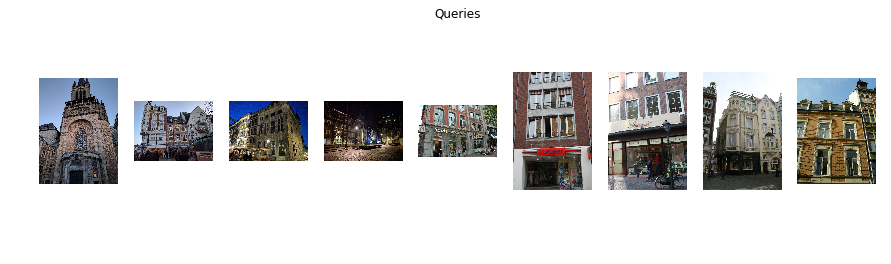

In [5]:
"""
2 day time queries
2 night time queries
2 dataset queries
"""
dataset_queries = [1, 500, 250, 2500, 4000]
path_to_queries = [
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_162905.jpg',
                   'data/AachenDayNight/images_upright/query/day/nexus5x/IMG_20161227_160713.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_172616.jpg',
                   'data/AachenDayNight/images_upright/query/night/nexus5x/IMG_20161227_191152.jpg',
                   #'data/AachenDayNight/images_upright/db/1.jpg',
                   #'data/AachenDayNight/images_upright/db/500.jpg'
                  ] + ['data/AachenDayNight/images_upright/db/'+str(i)+'.jpg' for i in dataset_queries]
n_queries = len(path_to_queries)
transform = transforms.Compose([transforms.Resize(resolution), transforms.CenterCrop(resolution)])
query_imgs_high_res = [load_image(path) for path in path_to_queries]
query_imgs_low_res = [transform(img) for img in query_imgs_high_res]
fig = plt.figure(figsize=(15,4))
plt.title('Queries')
plt.axis('off')
for i, img in enumerate(query_imgs_high_res):
    a = fig.add_subplot(1, len(query_imgs_high_res), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

## 1. Find similar images (global descriptors)

In [6]:
model = netvlad.vd16_pitts30k_conv5_3_max_dag(weights_path='data/teacher_models/netvlad_pytorch/vd16_pitts30k_conv5_3_max_dag.pth')
model.eval()
query_global_desc = [model(transforms.ToTensor()(img).unsqueeze(0)).detach().cpu().squeeze(0).numpy() for img in query_imgs_low_res]
query_global_desc = np.vstack(query_global_desc)
print(query_global_desc.shape)

(9, 131072)


Global descriptors for dataset are precalculated

In [7]:
print('Find nearest neighbors for queries (This may take some time)')
file = h5py.File("data/full_dataset_"+str(resolution)+".hdf5", "r")
verification = file['results']
len_feat_vec = int(verification[0][0])
print('%d data points with %d sized feature vectors'%(verification.shape[0], len_feat_vec))
nbrs = NearestNeighbors(n_neighbors=n_images).fit(verification[:,1:len_feat_vec+1])
print('Fitted')
#distances, indices = nbrs.kneighbors(verification[:n_samples,1:verification[0].shape[0]])
distances, indices = nbrs.kneighbors(query_global_desc)
file.close()

Find nearest neighbors for queries (This may take some time)
4328 data points with 131072 sized feature vectors
Fitted


In [8]:
dataset = aachen.AachenDayNight('data/AachenDayNight', True, train_split=-1,seed=0,#transform=transform,
                                input_types='img', #output_types=[],
                                real=True, verbose=False)

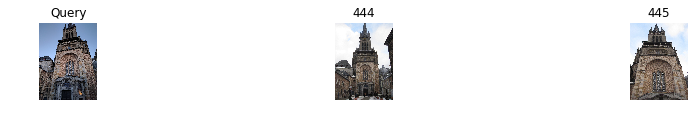

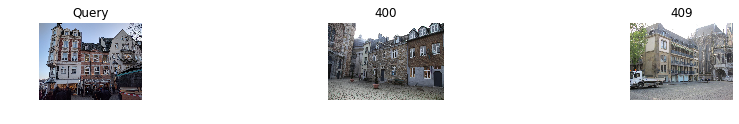

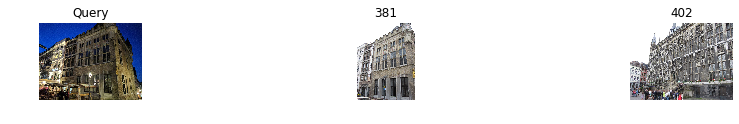

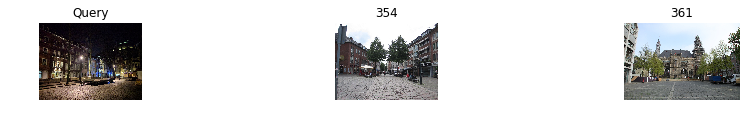

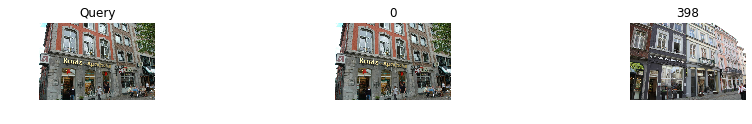

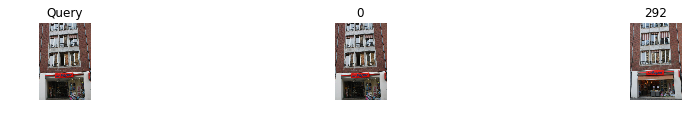

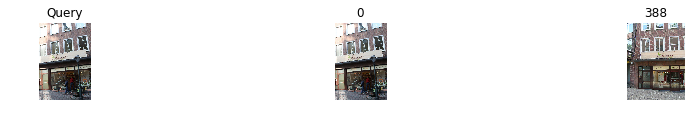

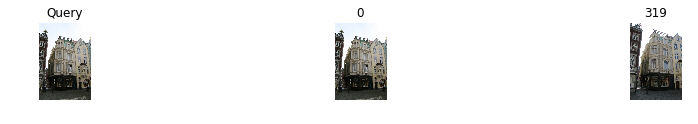

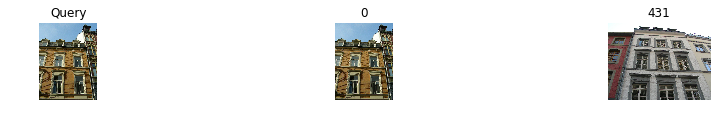

In [9]:
for i, query_img in enumerate(query_imgs_high_res):
    imgs = [query_img] 
    imgs = imgs + [dataset[j][0] for j in indices[i]]
    fig = plt.figure(figsize=(15,15))
    #plt.title('Neighbors')
    for j, img in enumerate(imgs):
        a = fig.add_subplot(n_queries, n_images+1, i*(n_images+1)+j+1)
        plt.imshow(img)
        if j > 0:
            plt.title('%.0f'%distances[i][j-1])
        else:
            plt.title('Query')
        plt.axis('off')
    plt.show()

## 2. Covisibility clustering

In [10]:
query_id = 0

In [11]:
cluster_query = [img_cluster[indices[query_id][0]]]
cluster_orig_ids = [indices[query_id][0]]
for i, ind in enumerate(indices[query_id]):
    if i == 0:
        continue
    point_set = img_cluster[ind]
    print('Match neighbor %d'%i)
    disjoint = False
    for j, c in enumerate(cluster_query):
        if ind in c:
            print('  - Can be matched to cluster')
            #print(point_set - (point_set-cluster))
            cluster_query[j] |= point_set
            disjoint = True
            break
    if not disjoint:
        print('  - New cluster created')
        cluster_orig_ids.append(ind)
        cluster_query.append(point_set)

Match neighbor 1
  - Can be matched to cluster


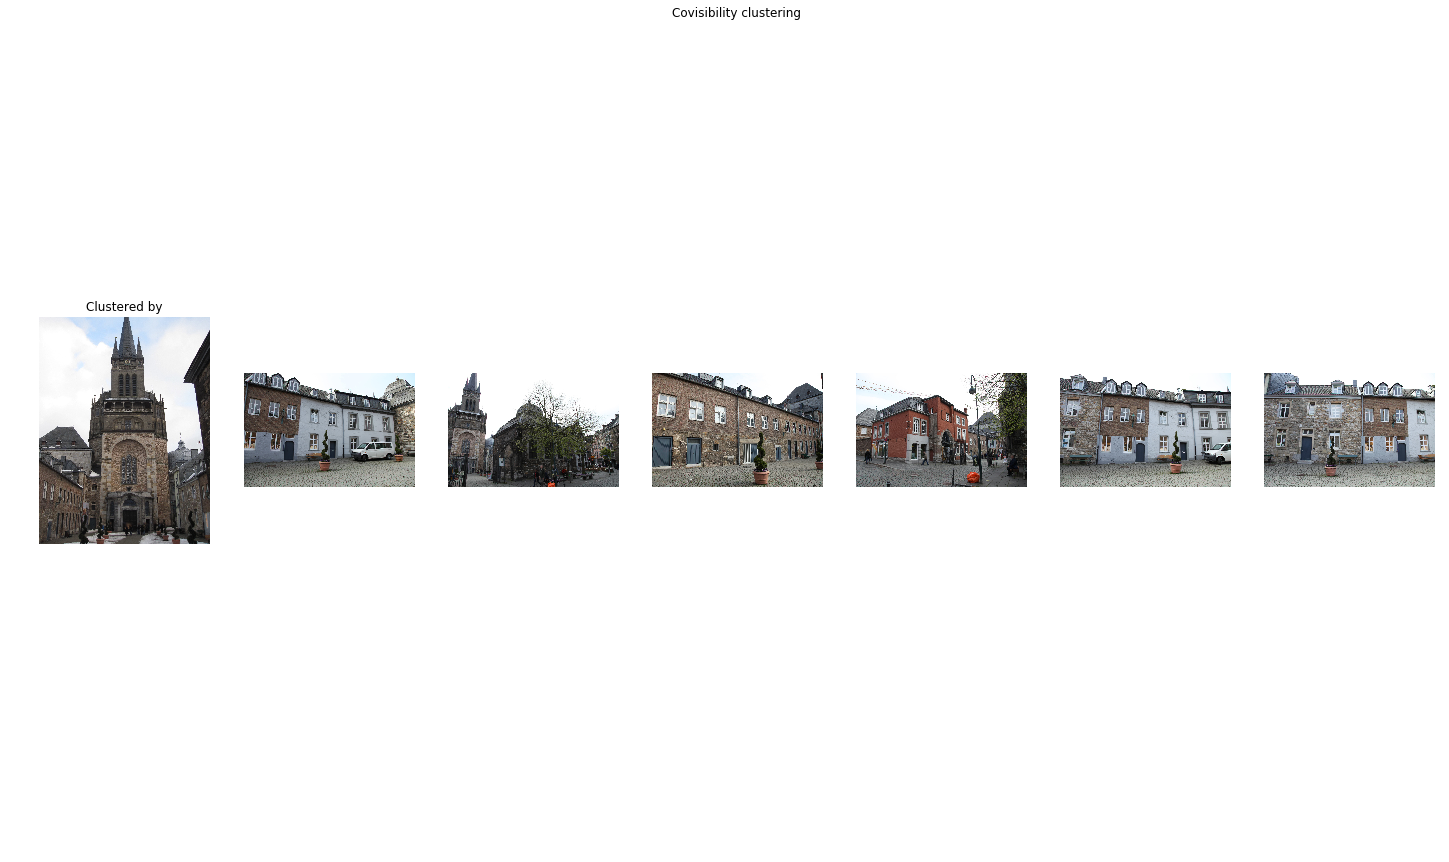

In [12]:
num_imgs_per_cluster = 6
fig = plt.figure(figsize=(25,15))
plt.title('Covisibility clustering')
plt.axis('off')
for i, cluster in enumerate(cluster_query):
    imgs = list(cluster_query[i])[:num_imgs_per_cluster]
    imgs = [dataset[cluster_orig_ids[i]][0]]+[dataset[j][0] for j in imgs]
    for j, img in enumerate(imgs):
        a = fig.add_subplot(len(cluster_query), len(imgs), i*len(imgs)+j+1)
        plt.imshow(img)
        plt.axis('off')
        if j == 0:
            plt.title('Clustered by')
plt.show()

In [13]:
cluster_points = []
for i, c in enumerate(cluster_query):
    imgs_cluster = list(c)
    points_cluster = set()
    for ind in imgs_cluster:
        points_cluster |= points_of_img[ind]
    points_cluster = list(points_cluster)

    mask = np.ones(points.shape[0],dtype=bool) #np.ones_like(a,dtype=bool)
    mask[points_cluster] = False

    cluster_points.append(points[~mask])
    print('%d\tpoints in cluster'%cluster_points[i].shape[0])
#other_points = points[mask]
#print('%d other points'%other_points.shape[0])

207423	points in cluster


Median is [745.557    -0.74667 -53.8775 ]


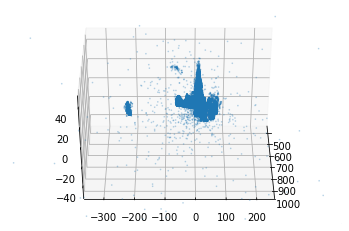

In [14]:
thresh = 300
ax = plt.axes(projection='3d')
#ax.scatter3D(other_points[:,0], other_points[:,2], other_points[:,1], s = 0.5, alpha = 0.01)
for cp in cluster_points:
    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
median = np.median(points, axis=0)
print('Median is %s'%median)
ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
plt.show()

## 3. Find local descriptors

In [15]:
test_id = cluster_orig_ids[0] #197

In [16]:
colmap_cursors = {}
def get_cursor(name):
    global colmap_cursors
    if name not in colmap_cursors:
        colmap_cursors[name] = sqlite3.connect(name).cursor()
    return colmap_cursors[name]


def descriptors_from_colmap_db(cursor, image_id):
    cursor.execute('SELECT cols, data FROM descriptors WHERE image_id=?;',(image_id,))
    feature_dim, blob = next(cursor)
    desc = np.frombuffer(blob, dtype=np.uint8).reshape(-1, feature_dim)
    return desc


def keypoints_from_colmap_db(cursor, image_id):
    cursor.execute('SELECT cols, data FROM keypoints WHERE image_id==?;',(image_id,))
    cols, blob = next(cursor)
    kpts = np.frombuffer(blob, dtype=np.float32).reshape(-1, cols)
    return kpts

def get_kpts_desc(cursor, image_id):
    kpts = keypoints_from_colmap_db(cursor, image_id)[:, :2]
    desc = descriptors_from_colmap_db(cursor, image_id)
    return kpts, desc

def get_img_id(cursor, img_name):
    img_id, = next(cursor.execute('SELECT image_id FROM images WHERE name="%s";'%img_name))
    return img_id

def get_img_id_dataset(cursor, dataset_id):
    db_query_name = 'db/%d.jpg'%dataset.get_img_id(test_id)
    return get_img_id(cursor, db_query_name)

def kpts_to_cv(kpts):
    cv_kpts = []
    for i, kpt in enumerate(kpts):
        cv_kpts.append(cv2.KeyPoint(x=kpt[0], y=kpt[1], _size=kpt_size))
    return cv_kpts


In [17]:
database_cursor = get_cursor('data/AachenDayNight/aachen.db')
query_cursor = get_cursor('queries.db')

kpt_size = 1.

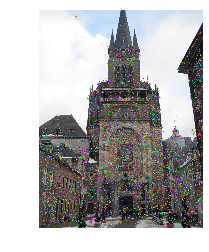

In [18]:
img_id = get_img_id_dataset(database_cursor, test_id)
neighbor_kpts, neighbor_desc = get_kpts_desc(database_cursor, img_id)
neighbor_kpts = kpts_to_cv(neighbor_kpts)
neighbor_img = cv2.drawKeypoints(np.array(dataset[test_id][0]),neighbor_kpts, None)
plt.imshow(neighbor_img)
plt.axis('off')
plt.show()

In [19]:
test_query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/query/', '')
print(test_query_path)

day/nexus5x/IMG_20161227_162905.jpg


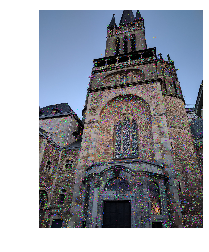

In [22]:
db_query_name = test_query_path
query_img_id = get_img_id(query_cursor, db_query_name)
query_kpts, query_desc = get_kpts_desc(query_cursor, query_img_id)

query_kpts = kpts_to_cv(query_kpts)
query_img = cv2.drawKeypoints(np.array(query_imgs_high_res[query_id]),query_kpts, None)
plt.imshow(query_img)
plt.axis('off')
plt.show()

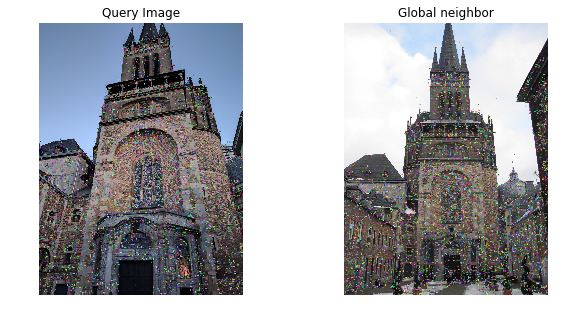

In [23]:
fig = plt.figure(figsize=(10,5))
a = fig.add_subplot(1, 2, 1)
plt.imshow(query_img)
plt.axis('off')
plt.title('Query Image')
a = fig.add_subplot(1,2,2)
plt.imshow(neighbor_img)
plt.axis('off')
plt.title('Global neighbor')
plt.show()

In [29]:
t = time.time()
matcher = cv2.BFMatcher(cv2.NORM_L2)
print(query_desc.shape)
print(neighbor_desc.shape)
matches = matcher.knnMatch(neighbor_desc, query_desc, k=2)
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        #matchesMask[i]=[1,0]
        good.append(m)
#m = m[matchesMask]
matches = good
        
t = time.time() - t
print('Matching took %d seconds\nFound %d matches'%(t, len(matches)))

(9028, 128)
(9687, 128)
Matching took 1 seconds
Found 63 matches


Start
Start draw matching
Finished draw matching - Plotting


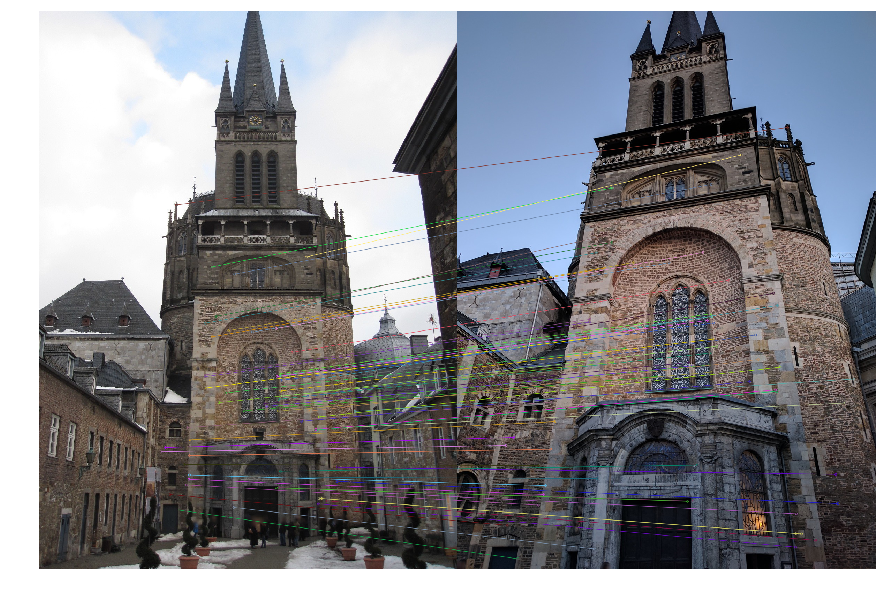

In [30]:
# cv2.drawMatchesKnn expects list of lists as matches.
#draw_params = dict(matchColor = (0,255,0),
#                   singlePointColor = (255,0,0),
#                   matchesMask = matchesMask,
#                   flags = 2)
img3 = np.empty((max(query_img.shape[0], neighbor_img.shape[0]), query_img.shape[1] + neighbor_img.shape[1], 3), dtype=np.uint8)
cv2.drawMatches(np.array(dataset[test_id][0]),neighbor_kpts,np.array(query_imgs_high_res[query_id]),query_kpts,matches,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
plt.figure(figsize=(15,15))
plt.imshow(img3)
plt.axis('off')
plt.show()

In [50]:
test_kpt = keypoints_from_colmap_db(database_cursor, get_img_id_dataset(database_cursor, 1))
print(test_kpt.shape)
print(measurements[1].keys())

(9687, 4)
dict_keys(['kpts', 'point_id'])


In [ ]:
points_to_match = []
key_point = []
breaker = 0
break_at = 5
ratio_thresh = 0.75
t = time.time()
for c in cluster_query:
    for img in c:
        """
        kpts = []
        point_ids = measurements[img]['point_id']
        for i, kpt in enumerate(measurements[img]['kpts']):
            kpts.append(cv2.KeyPoint(kpt[0], kpt[1], _size=med_kpt_size))
        if len(kpts) <= 0:
            continue
        _, desc = sift.compute(np.array(dataset[img][0]), kpts)
        """
        kpts, desc = get_kpts_desc(database_cursor, get_img_id_dataset(database_cursor, img))
        kpts = kpts_to_cv(kpts)
        matcher = cv2.BFMatcher(cv2.NORM_L2)
        matches = matcher.knnMatch(desc, query_desc, k=2)
        good = []
        for i,(m,n) in enumerate(matches):
            if m.distance < ratio_thresh*n.distance:
                #matchesMask[i]=[1,0]
                good.append(m)
        kpts_good = [query_kpts[i] for i in [g.trainIdx for g in good]]
        key_point += kpts_good
        points_to_match += [point_ids[i] for i in [g.queryIdx for g in good]]
        breaker += 1
        if breaker < break_at:
            fig = plt.figure(figsize=(10, 15))
            a = fig.add_subplot(1, 2, 1)
            plt.imshow(cv2.drawKeypoints(query_img,kpts_good, None))
            data_img = np.array(dataset[img][0])
            img3 = np.empty((max(query_sift_img.shape[0], data_img.shape[0]), query_sift_img.shape[1] + data_img.shape[1], 3), dtype=np.uint8)
            cv2.drawMatches(data_img,kpts,query_img,query_kpts,good,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
            a = fig.add_subplot(1, 2, 2)
            plt.imshow(img3)
            plt.show()
t = time.time() - t
print('Total matching time: %d seconds'%t)

In [ ]:
matched_points = points[points_to_match]
print(matched_points.mean(axis=0))
#matched_points[:,[2,1]] = matched_points[:,[1,2]]
#print(matched_points.mean(axis=0))
print(matched_points.shape)
matched_keypoints = np.vstack([np.array([x.pt[0], x.pt[1]]) for x in key_point])
print(matched_keypoints.shape)

## 5. Calculate pose

In [ ]:
query_path = path_to_queries[query_id].replace('data/AachenDayNight/images_upright/', '')
cm = camera_matrices[query_path]
camera_matrix = cm['cameraMatrix']
distortion_coeff = cm['rad_dist']
print(camera_matrix)
print(distortion_coeff)

In [ ]:
n_iter = 5000

In [ ]:
t = time.time()
dist_vec = np.array([distortion_coeff, 0, 0, 0])
success, R_vec, translation, inliers = cv2.solvePnPRansac(
        matched_points, matched_keypoints, camera_matrix, dist_vec,
        iterationsCount=n_iter, reprojectionError=8.,
        flags=cv2.SOLVEPNP_P3P)
t = time.time() - t
print('PnP RANSAC took %d seconds (%.2f/iteration)'%(t, float(t)/float(n_iter)))

In [ ]:
if success:
    print('Successful matching')
    print(inliers.shape)
else:
    print('Not succesful')
print(R_vec)
print(translation)


In [ ]:
print(matched_points[inliers].shape)
print(matched_keypoints[inliers].shape)

In [ ]:
min_inliers = 10

if success:
    inliers = inliers[:, 0] if len(inliers.shape) > 1 else inliers
    num_inliers = len(inliers)
    inlier_ratio = len(inliers) / len(matched_keypoints)
    success &= num_inliers >= min_inliers

    ret, R_vec, t = cv2.solvePnP(
                matched_points[inliers], matched_keypoints[inliers], camera_matrix,
                dist_vec, rvec=R_vec, tvec=translation, useExtrinsicGuess=True,
                flags=cv2.SOLVEPNP_ITERATIVE)
    assert ret

    query_T_w = np.eye(4)
    query_T_w[:3, :3] = cv2.Rodrigues(R_vec)[0]
    query_T_w[:3, 3] = t[:, 0]
    w_T_query = np.linalg.inv(query_T_w)

    #ret = LocResult(success, num_inliers, inlier_ratio, w_T_query)

In [ ]:
print(w_T_query)
print('Result: %s'%w_T_query[:3, 3])
if query_id > 3:
    pose_stats_filename = os.path.join('data/AachenDayNight/', 'pose_stats.txt')
    mean_t, std_t = np.loadtxt(pose_stats_filename)
    position = dataset[dataset_queries[query_id-4]][1][:3]
    position = position*std_t + mean_t
    print('Groundtruth: %s'%str(position))

    


## old code




In [ ]:
## stop notebook run all
1.0/0.0

In [ ]:
## Now all clusters
t = time.time()
kpts_des = {}
place_lms = []
for c in cluster_query:
    for img in c:
        kpts = []
        point_ids = measurements[img]['point_id']
        place_lms += point_ids
        for i, kpt in enumerate(measurements[img]['kpts']):
            kpts.append(cv2.KeyPoint(kpt[0], kpt[1], _size=med_kpt_size))
        if len(kpts) <= 0:
            continue
        kpts_des[img] = sift.compute(np.array(dataset[img][0]), kpts)
place_lms = np.array(place_lms)
t = time.time() - t
print('Took %d seconds'%t)

In [ ]:
random_id = list(cluster_query[0])[12]
plt.imshow(cv2.drawKeypoints(np.array(dataset[random_id][0]),kpts_des[random_id][0], None))
plt.show()

In [ ]:
print(len(kpts_des))
print(sum([len(c) for c in cluster_query]))
print(place_lms.shape)
print(kpts_des[random_id][1].shape)

In [ ]:
"""
From https://github.com/ethz-asl/hfnet
"""

def matches_cv2np(matches_cv):
    matches_np = np.int32([[m.queryIdx, m.trainIdx] for m in matches_cv])
    distances = np.float32([m.distance for m in matches_cv])
    return matches_np.reshape(-1, 2), distances

query_des = query_des.astype(np.float32, copy=False)
dataset_des = np.concatenate([kpts_des[x][1] for x in kpts_des]).astype(np.float32, copy=False)
#img_match_ids = [x for i in range(len(kpts_des[x][1])) for x in kpts_des]
#print(len(img_match_ids))


print(type(query_des))
print(type(dataset_des))
print(query_des.shape)
print(dataset_des.shape)

matcher = cv2.BFMatcher(cv2.NORM_L2)
m = matcher.knnMatch(dataset_des, query_des, k=2)

matches1, matches2 = list(zip(*m))
(matches1, dist1) = matches_cv2np(matches1)
(matches2, dist2) = matches_cv2np(matches2)
print(matches1.shape)
print(matches2.shape)
print('Done matching: %d matches'%len(m))

In [ ]:
ratio_thresh = 0.70
#print(matches1[:5])
#print(matches2[:5])
#print(matches1[103])

In [ ]:
print(place_lms.shape)
## Index testing cannot work as we do not know which points are in query (problem would be already solved)
#good = (place_lms[matches1[:, 1]] == place_lms[matches2[:, 1]])
good = (dist1/dist2 < ratio_thresh)
matches_good = matches1[good]

In [ ]:
print(good[:10])
print(matches_good[0])
#print(len([g for g in good if not g]))
#print(len(matches))

In [ ]:
cnt = 0
img_shown = 0
for c in cluster_query:
    for img in c:
        kpt = kpts_des[img][0]
        n = len(kpt)
        cnt += n
        print('%d:%d'%(cnt-n,cnt))
        if not np.any(good[cnt-n:cnt]):
            continue
        
        img_shown += 1
        if img_shown > 5:
            break
        #matches_img = [i for x in m[cnt-n:cnt] for i in x if x[0].distance < ratio_thresh*x[1].distance]
        matches_img = [cv2.DMatch()]
        data_img = np.array(dataset[img][0])
        img3 = np.empty((max(query_sift_img.shape[0], data_img.shape[0]), query_sift_img.shape[1] + data_img.shape[1], 3), dtype=np.uint8)
        cv2.drawMatches(data_img,kpt,query_img,query_kpts,matches_img,outImg=img3,matchColor=None, singlePointColor=(255, 255, 255), flags=2)# **draw_params)
        plt.imshow(img3)
        plt.axis('off')
        plt.show()

In [ ]:
matched_points = np.stack([points[place_lms[i]] for i in matches[:, 0]])
matched_kpts = np.vstack([np.array(query_kpts[i].pt) for i in matches[:, 1]])

In [ ]:
print(matched_points.shape)
print(matched_kpts.shape)

In [ ]:
thresh = 300
ax = plt.axes(projection='3d')
ax.scatter3D(matched_points[:,0], matched_points[:,2], matched_points[:,1], s = 1.5, alpha = 0.5)
#for cp in cluster_points:
#    ax.scatter3D(cp[:,0], cp[:,2], cp[:,1], s = 0.5, alpha = 0.25)
#ax.scatter3D(translation[0], translation[2], translation[1], s=25, alpha=1.0)
median = np.median(points, axis=0)
print('Median is %s'%median)
#ax.set_xlim3d(median[0]-thresh,median[0]+thresh)#min(sift_points[:,0]),min(sift_points[:,0])+max_dist)
#ax.set_ylim3d(median[2]-thresh,median[2]+thresh)#min(sift_points[:,1]),min(sift_points[:,1])+max_dist)
#ax.set_zlim3d(median[1]-50, median[1]+50)#min(sift_points[:,2]),min(sift_points[:,2])+max_dist)
ax.view_init(elev=35., azim=0)
plt.show()